In [886]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install selenium
#!pip install beautifulsoup4
#!sudo apt-get install chromium-chromedriver
#!brew install --cask chromedriver
#!pip install textract
#!pip install tabula-py
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import re
import urllib
import os
import time
import textract
import tabula
import ast
from tabula.io import read_pdf

In [887]:
the_web_page="https://www.ge.ch/recherche-entreprises-dans-registre-du-commerce-geneve"
business_name_search = input("Enter type of company: ")
print(business_name_search)
#business_name_search='immobilier'
folder_web_scrap='webscraping'+os.path.sep+business_name_search.replace(" ", "_")

Enter type of company: real estate
real estate


In [897]:
chrome_options= Options()
#configure path of downloaded pdf file
preferences = {
                "profile.default_content_settings.popups": 0,
                "download.default_directory": os.getcwd() + os.path.sep + folder_web_scrap,
                "directory_upgrade": True
            }
chrome_options.add_experimental_option('prefs', preferences)
driver=webdriver.Chrome(options=chrome_options)

In [898]:
driver.get(the_web_page)
driver.switch_to.frame("mainFrame")

#search for the company type
driver.find_element_by_id("companyName").clear()
driver.find_element_by_id("companyName").send_keys(business_name_search)
time.sleep(2)
driver.find_element_by_xpath('//*[@id="companySearch"]/table[2]/tbody/tr[8]/td[2]/span/label[2]').click() # show 5000 results
time.sleep(2)
driver.find_element_by_id("companySearch_display").click()
time.sleep(3)
driver.switch_to.default_content()

# accept cookies
driver.find_element_by_xpath('//*[@id="popup-buttons"]/button[2]').click() 

driver.maximize_window()
driver.switch_to.frame("mainFrame")

/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/2157204220.py:5: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id("companyName").clear()
/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/2157204220.py:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id("companyName").send_keys(business_name_search)
/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/2157204220.py:8: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath('//*[@id="companySearch"]/table[2]/tbody/tr[8]/td[2]/span/label[2]').click() # show 5000 results
/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/2157204220.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.fi

## Download pdf files

In [901]:
# total number of companies found
the_len=int(driver.find_element_by_xpath('//*[@id="resultDiv"]/h3').text.split(" ", 1)[0])
print("total number of files found:", the_len)
download_files_yn = input("Do you want to download pdf files from website (type yes or no)?  ")
#print(download_files_yn)

/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/22970536.py:2: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  the_len=int(driver.find_element_by_xpath('//*[@id="resultDiv"]/h3').text.split(" ", 1)[0])


total number of files found: 117
Do you want to download pdf files from website (type yes or no)?  no


In [902]:
if download_files_yn=="yes":
    tot_num_files=0
    bad_files=[]
    for ll in range(0,the_len+1):
        try:
                # download pdf file in the folder defined
                driver.find_element_by_xpath('//*[@id="resultDiv"]/table/tbody/tr[{ll}]/td[2]/a/img'.format(ll=ll)).click()
                tot_num_files+=1 
                time.sleep(2)
        except:
                if ll>5000:
                    print('moving to next page')
                    driver.find_element_by_xpath('//*[@id="navigationDivDown"]/table/tbody/tr/td[1]/a[5]').click() 
                    time.sleep(1.5)
                    tot_num_files+=1 
                    continue
                else:
                    bad_files.append(ll)
                    print('no file')
                    time.sleep(2)
                    continue
        print('tot_num_files=',tot_num_files)                     
    print("done saving pdf files to folder {}".format(folder_web_scrap))
else:
    print("not downloading pdf files")

not downloading pdf files


## Read downloaded pdf files -> pd -> dic->zip

In [903]:
driver.close()

In [904]:
lits_all_files=[f for f in os.listdir(folder_web_scrap) if f.endswith('.pdf')]
len(lits_all_files)

116

In [863]:
companies=[] 
people=[] 
ho_location=[] 
print("start reading pdf files to extract info")
for ll in range(0,len(lits_all_files)):
    the_file=lits_all_files[ll]
    print(ll,the_file)
    df = tabula.io.read_pdf(folder_web_scrap+os.path.sep+the_file, pages='all')
    
    #get company name
    try:
        companies.append(df[0][~df[0].reset_index(drop=True).iloc[:,0].isna()].iloc[0,1])
    except:
        companies.append('NaN')
        print('no companies')
    #get company head office location    
    try:        
        ho_location.append(df[0][~df[0].reset_index(drop=True).iloc[:,0].isna()].iloc[1,1])
    except:
        ho_location.append('NaN')
        print('no location')  
    #get people/companies involved in companies   
    if [col for dd in range(0,len(df[1:])+1) for col in df[dd].columns if 'et personnes'  in col ]:
        dd=[[dd,col] for dd in range(0,len(df[1:])+1) for col in df[dd].columns if 'et personnes'  in col ][0][0]
    try:
        df[dd] = df[dd].dropna(axis = 1, how = 'all')
        spike_cols =[col for col in df[dd].columns if 'et personnes' in col]
        ts=df[dd][spike_cols[0]]#.iloc[:,2]
        the_p=[ts.get(pp).split(',')[0] for pp in range(1,len(ts)+1)]
    except:    
        try:
            new_header2 = df[dd].iloc[0] #grab the first row for the header
            df[dd] = df[dd][1:] #take the data less the header row
            df[dd].columns = new_header2 #set the header row as the df header  
            df[dd] = df[dd].dropna(axis = 1, how = 'all')
            #print(dd, df[dd].columns)
            spike_cols =[col for col in df[dd].columns if 'Nom et ' in col]
            #print(spike_cols)
            ts=df[dd][spike_cols[0]].dropna().reset_index(drop=True)#.iloc[:,2]
            the_p=[ts.get(pp).split(',')[0] for pp in range(0,len(ts))]    
        except:    
            the_p='NaN'
            print('no people')
    people.append(the_p)
    print(the_p)             
print("done processing pdf files to df")

0 CHE-373.454.717.pdf
['Kupferschmid Sarah', 'Vernier', 'Tissot Christine', 'Kupferschmid Christian', 'Vernier', 'Tissot Grégoire']
1 CHE-102.530.634.pdf
['Bertoldi Laurent', 'Carriero Pietro', 'Karasso Rupf Flora', 'OGH expertises comptables et fiscales SA organe de révision', '(CHE-102.169.082)']
2 CHE-102.525.981.pdf
['Schneider Théodore dit Ted', 'Evilard']
3 CHE-395.949.909.pdf
['Germanier Jean Charles Marc', 'Conthey']
4 CHE-100.505.677.pdf
['Ferrillo Raphaël', 'Berthet Stéphane', 'Doudin Sandro', '"Fiduciaire Brandt SA" ']
5 CHE-100.505.111.pdf
['Turrettini Arnaud']
6 CHE-181.988.931.pdf
['Bourn Daniel']
7 CHE-100.383.842.pdf
['Opériol Jean']
8 CHE-100.154.833.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
9 CHE-269.553.942.pdf
['Falk-Vairant Jean-Pierre']
10 CHE-355.716.457.pdf
['Hassein

['Exposito Mendez José Ramon', 'Genève']
88 CHE-312.532.676.pdf
['Tuaz Nathan', 'F']
89 CHE-103.212.409.pdf
['Keller Jean-Daniel', 'Hatreba Revisions- und Treuhand AG (CHE- organe de révision', '107.798.776)']
90 CHE-103.144.328.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
91 CHE-100.382.475.pdf
['Dunand Michel']
92 CHE-100.600.063.pdf
['Dunand Michel']
93 CHE-103.119.856.pdf
['Dumont Jacques', 'de Haan Thierry']
94 CHE-102.532.685.pdf
['Roth Jean-Daniel', 'Bougeries', 'Niemetz Jérôme', 'Flückiger Alain']
95 CHE-103.208.046.pdf
['Comte Patricia']
96 CHE-100.418.191.pdf
['Staebler Daniel']
97 CHE-205.151.593.pdf
['Kügele Bernhard', 'Chambésy', 'Kügele Danièle']
98 CHE-102.844.498.pdf
['Roch Yves', 'Carletti Christian', 'Carletti Serge', 'Roch Michelle', '"Société fiduciaire d\'Expertise et de R

['Knobel John Béatrice', 'Piermont Jonathan', 'Rouger Patrick', '"Gestoval Société Fiduciaire"']
179 CHE-102.537.263.pdf
['Bordier Alain', 'Penet Michel']
180 CHE-100.141.434.pdf
['Prudent Bertrand', 'Prudent Raymond', 'MAR']
181 CHE-100.503.796.pdf
['Jörg Philippe']
182 CHE-103.159.092.pdf
['Moser François', 'Adjadj Malek Alexandre', 'Dominicé Michel', 'Verifid Révision SA (CH-660-0073994-6)', 'Genève']
183 CHE-115.073.675.pdf
['Pirker Christian', 'parts de CHF 100', 'Felicite Jérôme', 'parts de CHF 100']
184 CHE-100.401.948.pdf
['Herzog Roger', 'Dambacher Stefan', 'Paratte Alain', 'Räbsamen Simon', 'Wapp Thomas']
185 CHE-103.122.522.pdf
['de Haan Thierry', 'Bellerive', 'Dumont Jacques', 'Bellerive', 'ACF FIDUCIAIRE SA (CHE-107.742.089)', 'Genève']
186 CHE-102.539.368.pdf
['Roth Jean-Daniel', 'Bougeries', 'Niemetz Jérôme', 'Flückiger Alain']
187 CHE-100.155.206.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias',

['Ferrillo Raphaël', 'Berthet Stéphane', 'Doudin Sandro', '"Fiduciaire Brandt SA" ']
268 CHE-100.859.112.pdf
['Heuvelmans Perret Carla', 'Verifid Révision SA (CH-660-0073994-6)', 'Genève']
269 CHE-463.281.344.pdf
['Bornhauser Bertrand', 'les Alpilles', 'Levesque-Bornhauser Anne', 'Bellerive']
270 CHE-103.248.117.pdf
['Aberle Claude', 'Verifid Révision SA (CH-660-0073994-6)', 'Genève']
271 CHE-102.534.566.pdf
['Minkoff Francis']
272 CHE-103.218.323.pdf
['Cavadini Olivia', 'Teyssot Ludovic']
273 CHE-100.427.801.pdf
['Dunand Michel']
274 CHE-101.111.335.pdf
['Dumonthay Jean-Marc']
275 CHE-102.917.938.pdf
['Prost Philippe']
276 CHE-403.772.696.pdf
['Eichenberger Claude']
277 CHE-112.458.240.pdf
['Nimis Olivier', 'Adler Gross Patricia']
278 CHE-100.460.804.pdf
['Favre Michel John', 'Bellerive']
279 CHE-428.986.167.pdf
['Ribordy Jean', 'Rollier Patricia', 'Derivry Annabelle', 'Genevois', 'Volpicelli Massimiliano', 'Lancy']
280 CHE-273.888.564.pdf
['Grandet Benjamin']
281 CHE-103.291.840.pdf


['Giot Sarah']
357 CHE-213.871.608.pdf
['Grumbach Philippe', 'de Preux Michel']
358 CHE-273.696.473.pdf
['Cazeaux Stéphanie']
359 CHE-103.189.087.pdf
['Gamblin Frédéric', 'Swiss Audit & Fiduciary Services SA (CH-660- organe de révision', '3412011-1)']
360 CHE-100.444.900.pdf
['Induni Jean-Pierre']
361 CHE-135.949.454.pdf
['Juillerat Alexandre Michel', 'Bourg']
362 CHE-303.664.149.pdf
['Rochat  Frédéric', 'Bellerive']
363 CHE-103.340.102.pdf
['Guyot Denise', 'A. GAUTIER', '2102001-6)']
364 CHE-100.855.781.pdf
['Grosclaude Jean-Pierre']
365 CHE-102.530.522.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
366 CHE-396.429.363.pdf
['Ambrosini Gilles']
367 CHE-243.139.506.pdf
['SG-Courtage & Régie SA (CHE-371.240.849)', 'à Genève', 'Caminati Thierry']
368 CHE-100.475.349.pdf
['Chevrier Emmanuel', 'Jaton

['Pahud Alexandre']
449 CHE-100.597.975.pdf
['Lassus Thierry Bernard André']
450 CHE-164.507.236.pdf
['Galanis Konstantinos']
451 CHE-274.736.023.pdf
['Moser François']
452 CHE-253.311.103.pdf
['Pillet Patrick']
453 CHE-103.140.810.pdf
['Waeber Julien', 'Julen David', 'Experaudit SA (CHE-100.089.928)']
454 CHE-309.587.955.pdf
['Magnin Michel Edouard Henri', 'Meyrin']
455 CHE-108.461.664.pdf
['Comte Alain']
456 CHE-100.454.904.pdf
['Brun Jean-Pierre', 'ECHO SA (CHE-107.749.631)']
457 CHE-100.599.922.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
458 CHE-115.643.118.pdf
['Dieu François', 'Bellerive', 'Castella Stéphanie', 'Ouates', 'Grossmann Anne']
459 CHE-114.020.216.pdf
['Roverano Stéphane', 'les-Ouates']
460 CHE-200.248.883.pdf
['Chapel Vincent']
461 CHE-100.418.280.pdf
['Riondel Bernard', 'De

['Bongard Jacques']
549 CHE-103.326.510.pdf
['Guhl Joëlle']
550 CHE-403.130.055.pdf
['Fournier Joseph Dominique', 'Hohberger Eric', 'Fournier Esther', 'COLBA SA (CHE-470.549.227)']
551 CHE-100.600.181.pdf
['Gavillet Michel', 'Beuchat Michel', '(GE)', 'Fromager Catherine', 'Fiduciaire Nouvelle SA (CH-660-0033969-3)', 'Genève']
552 CHE-242.297.338.pdf
['Schwerdtel Gunter', 'Carouge (GE)']
553 CHE-100.436.705.pdf
['El Rahi Elias']
554 CHE-115.846.845.pdf
['Haniph Christine', "pour 20 parts de CHF 1'000"]
555 CHE-102.694.098.pdf
['Snell-Cousin Diane', 'Chambésy', 'Chevalley Missia', 'Chambésy', 'Cousin Anicée', 'Cousin Daniel', "Société Fiduciaire et d'Etudes Fiscales SA organe de révision", '(CH-660-0169957-4)']
556 CHE-109.616.662.pdf
['Hofer Hans', 'Säuberli Olivier', 'Sauge Corine']
557 CHE-448.109.577.pdf
['Gabella Antoine', 'pour 200 parts de CHF 100']
558 CHE-402.927.275.pdf
['Semir Arslanagic ', 'Prohic Nerma']
559 CHE-112.765.185.pdf
['Leopizzi Biagio', 'Frachet Claude-Alain', 'Pe

['Buchs Jean-Bernard Philibert']
641 CHE-100.861.103.pdf
['Bloch François', 'Bloch Laurent', 'Bloch Michel', 'Bloch Muriel', 'Lehmann Eliane']
642 CHE-115.794.757.pdf
['Chatila Abdallah', 'Berney Associés Audit SA (CHE-102.136.421)', 'à Genève', 'Azrak-Poznansky Isabelle', 'Cretegny Yves', 'Céligny', 'Delacuisine Mex Blaise', 'Garda Manuel', 'Spierer Laurent']
643 CHE-100.462.329.pdf
['Policino Jade', 'Policino Johan', 'Berney et Associés SA Société Fiduciaire organe de révision', '(CHE-102.136.421)']
644 CHE-272.048.225.pdf
['Maréchal-Dominé Anne']
645 CHE-100.155.241.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
646 CHE-115.213.947.pdf
no people
NaN
647 CHE-100.453.431.pdf
['Poncet Angélique']
648 CHE-102.531.711.pdf
['Krähenmann Thomas', 'Büschi Bernard', 'Gremaud Joëlle', 'Oetiker Rauner He

['Lazzarotto Lucien', 'Société Fiduciaire Prévisia SA (CHE- organe de révision', '107.712.668)']
732 CHE-103.595.808.pdf
['Bonnefous Michel', 'Bellerive secrétaire', 'Bonnefous Philippe', 'Bellerive']
733 CHE-103.201.363.pdf
['Buchs Jean-Bernard']
734 CHE-100.436.728.pdf
['Perrot Jacques', 'Comtesas + Gerficom SA (CH-660-0151968-2)', 'à Genève', 'Pitteloud Fabienne']
735 CHE-108.748.031.pdf
no people
NaN
736 CHE-115.153.771.pdf
['Andreoli Sonia']
737 CHE-100.431.754.pdf
['Tournier Bertrand', 'Bougeries']
738 CHE-333.734.866.pdf
['Pelletier Sylvain', 'Rouxel Annick', 'F', 'Sacerdote Rémi', 'RSM Audit Switzerland SA (CHE- organe de révision', '112.665.603)']
739 CHE-102.531.272.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller  Olivier', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
740 CHE-102.934.948.pdf
['Buchs Jean-Bernard', 'Verifid Révision SA (CHE

['de Haan Thierry', 'Dzierlatka Nicolas', 'Carouge GE']
816 CHE-103.217.619.pdf
['Zehentmair Augustin', 'Feldkirchen', 'Müllhaupt Walter', 'Galland Virginie', 'Wechsler & Partner Unternehmensberatung organe de révision', 'AG (CH-130.0.008.860-9)']
817 CHE-103.480.140.pdf
['Ophir Yarom', 'Bichunsky Gerald', 'Londres', 'Isler Manuel Vincent', 'PricewaterhouseCoopers SA ', 'Pully']
818 CHE-103.121.439.pdf
['Cadei Federico', 'Cadei Sandra']
819 CHE-101.000.405.pdf
['Garzon Antonio', "parts de CHF 1'000", 'Roch Barthélémy', "pour 10 parts de CHF 1'000", 'Fiduciaire Tecafin SA (CHE-105.820.117)', 'Genève']
820 CHE-103.173.293.pdf
['Gombo Jean']
821 CHE-103.144.914.pdf
['Bordier Alain', 'Fiduciaire du Mandement SA (CH-660- organe de révision', '0994991-6)']
822 CHE-116.039.310.pdf
['Binder Frédéric', 'Zu Salm-Salm Christian']
823 CHE-304.917.034.pdf
['Wachsstock Ouri']
824 CHE-100.155.962.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon

['Brun Jean-Pierre', 'ECHO SA (CHE-107.749.631)']
907 CHE-100.154.804.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
908 CHE-100.601.720.pdf
['van Muyden François']
909 CHE-100.601.708.pdf
['Roder Jean-Claude']
910 CHE-114.995.224.pdf
no people
NaN
911 CHE-102.531.438.pdf
['Roth Jean-Daniel', 'Bougeries', 'Niemetz Jérôme', 'Flückiger Alain']
912 CHE-102.539.204.pdf
['Delacuisine Mex Blaise', 'Pahud Julien', 'CONSILIO SA ']
913 CHE-225.560.753.pdf
['Rivollet Pascal', 'Bianchi Pascal']
914 CHE-208.758.656.pdf
['Galvao Davi', 'Galvao Nina', 'MCO', 'Anca Fiduciaire SA (CHE-103.784.918)', 'Genève']
915 CHE-113.757.797.pdf
['Tarimo Anouck', '100 parts de CHF 100 présidente', 'Tarimo Donald', 'parts de CHF 100']
916 CHE-103.325.930.pdf
['Kirkland Larry James']
917 CHE-102.524.579.pdf
no people
NaN
918 

['Pradervand Didier']
999 CHE-307.448.805.pdf
['Jucker-Diserens Brigitte']
1000 CHE-109.595.600.pdf
['Henriod Nadine', 'parts de CHF 100']
1001 CHE-103.201.328.pdf
['Ogi Jean-Pierre', 'Ogi Albert', 'Ogi Manuel']
1002 CHE-102.531.013.pdf
['Brüllmann Daniel', 'Balducci Otter Nanda', 'Lauterbrunnen', 'Fäs Urs', 'Grossmann Reto', 'Pantaleon', 'Jäger Matthias', 'Oberrieden', 'Jelsch Xénia', 'Müller Oliver', 'Jona', 'Roten Jean-Michel', 'Laufon', 'Strub Martin', 'Hägendorf']
1003 CHE-178.810.787.pdf
['Jerusalmi Rose-Marie', 'Dominguez José']
1004 CHE-166.006.063.pdf
['Hani Mehdi', 'Luiz Devis', 'Fidial Audit SA (CHE-110.058.556)']
1005 CHE-114.966.470.pdf
['Pfeffer André', "parts de CHF 1'000"]
1006 CHE-337.762.376.pdf
['Duboux Monique']
1007 CHE-446.303.660.pdf
['Michel Florent', 'pour 100 parts de CHF 100', 'Michel-Ligeza Caroline', 'près-Céligny']
1008 CHE-442.887.535.pdf
['dos Santos Dragon Ana Paula']
1009 CHE-110.146.901.pdf
['Hiltbrand François']
1010 CHE-243.562.595.pdf
['Fazekas Imr

In [905]:
save_dict = input("Do you want to save info extracted from files read (type yes or no)?  ")

Do you want to save info extracted from files read (type yes or no)?  no


In [907]:
if save_dict=="yes":
    ddd=dict([('company', companies), ('location', ho_location), ('people',people)])
    df = pd.DataFrame.from_dict(ddd, orient='index') # convert dict to dataframe
    df = (df.T)
    busn_no_spaces=business_name_search.replace(" ", "_")
    df.to_excel('{}_dict.xlsx'.format(busn_no_spaces))
    print('writing', '{}_dict.xlsx'.format(busn_no_spaces))
else:
    print("not saving info extracted from files")

not saving info extracted from files


calling and running data_analysis notebook

~~~~~~~~~~~~~~~~~~~~~~~~data analysis~~~~~~~~~~~~~~~~~~~~~~~~~~~~

total number of companies who have people info: 1143
no same company names in real_estate and immobilier, so we can join them
total number of companies after removing duplicates: 1139


/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/725189811.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=re_df_clean.append(immo_df_clean)


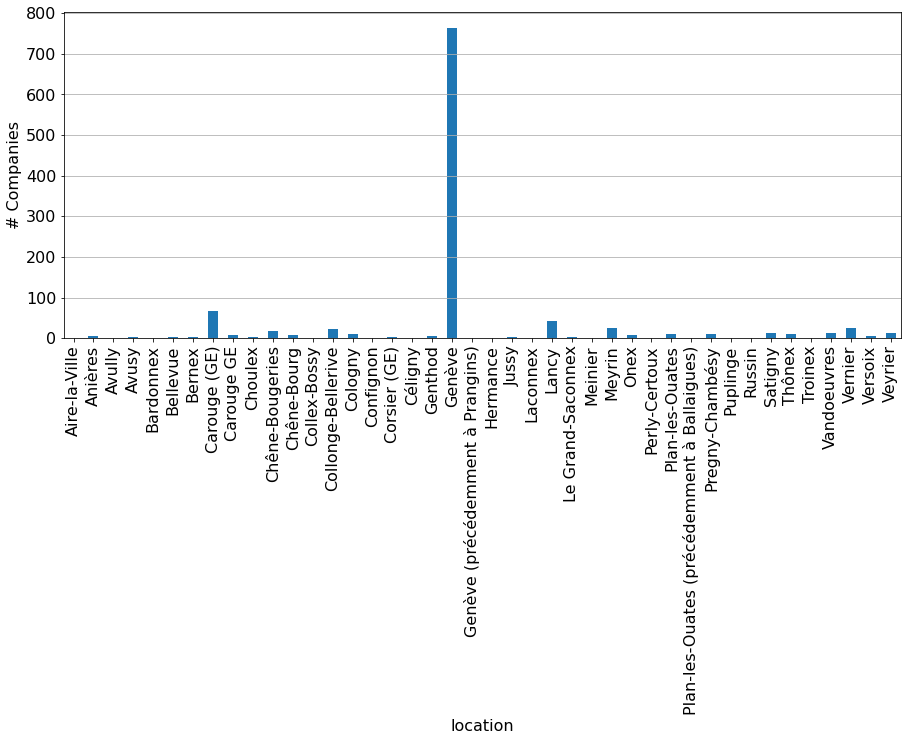

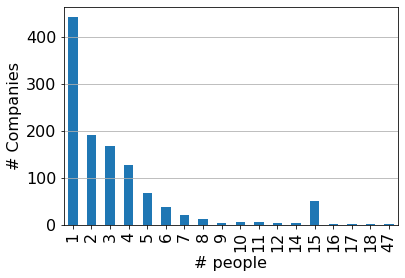

num of people before filtering: 3744
num of people after filtering:  2768
num of unique people:  1596
some people appear in more than 1 companies -> interactions


/var/folders/7y/mqj_tfm964q8kcsr72k44zbm0000gn/T/ipykernel_61279/2007887913.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  companies_multi.append(df[df.people.str.contains(people_dupl[ll])].company)


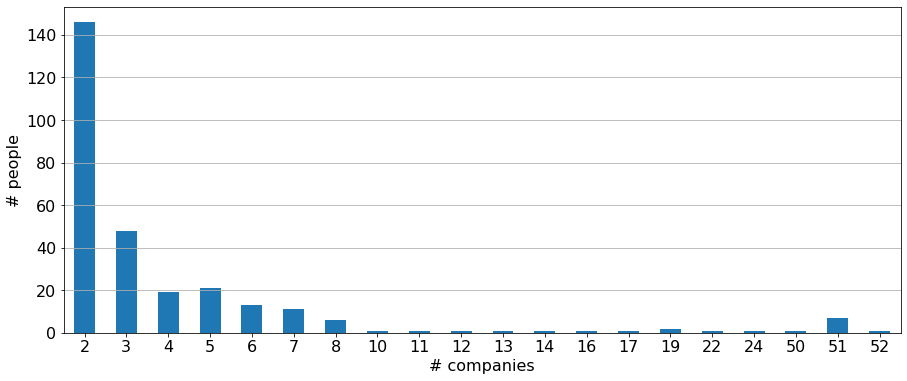

no company names are found in people list of other companies
1


2

In [913]:
print("calling and running data_analysis notebook\n")
print("~~~~~~~~~~~~~~~~~~~~~~~~data analysis~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
%run ./data_analysis.ipynb
def foo():
    print(1)
    return 2
foo()